In [1]:
import tensorflow as tf
import numpy as np
import wfdb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import signal
import neurokit2 as nk
import shap
from scipy.ndimage import uniform_filter
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.momentum_iterative_method import momentum_iterative_method
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.tf2.attacks.carlini_wagner_l2 import carlini_wagner_l2
from cleverhans.tf2.attacks.madry_et_al import madry_et_al
from scipy.signal import butter, filtfilt, lfilter
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
def load_model(model_path):
    if not tf.io.gfile.exists(model_path):
        raise FileNotFoundError(f"Model file {model_path} not found.")
    
    model = tf.keras.models.load_model(model_path, compile=False)
    return model

In [3]:
def resample_signal(original_signal, original_fs, target_fs=100):
    if original_fs == target_fs:
        return original_signal
    fs_ratio = target_fs / original_fs
    return signal.resample(original_signal, int(original_signal.shape[0] * fs_ratio))

In [4]:
def adjust_signal_length(signal, target_length):
    """Pad or truncate signal to target length"""
    if signal.shape[0] < target_length:
        return np.pad(signal, ((0, target_length - signal.shape[0]), (0, 0)), mode='constant')
    return signal[:target_length]

In [5]:
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv1D):
            return layer.name
    raise ValueError("No convolutional layer found in the model.")

In [6]:
def compute_grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        class_idx = tf.argmax(preds[0])
        class_output = preds[:, class_idx]
        grads = tape.gradient(class_output, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_output = conv_outputs[0] * pooled_grads  # Removed `.numpy()`

    heatmap = np.mean(conv_output.numpy(), axis=-1)  # Now apply .numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap = (heatmap - np.min(heatmap)) / (np.ptp(heatmap) + 1e-8)
    
    return heatmap, class_idx.numpy()

In [7]:
def plot_ecg_with_gradcam(signal, heatmap, lead_names, fs, class_idx):
    num_leads = signal.shape[1]
    time = np.arange(signal.shape[0]) / fs
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(num_leads, 1, figure=fig)
    heatmap_normalized = (heatmap - np.min(heatmap)) / (np.ptp(heatmap) + 1e-8)
    for lead in range(num_leads):
        ax = fig.add_subplot(gs[lead, 0])
        vertical_offset = lead * 3
        ax.plot(time, signal[:, lead] + vertical_offset, linewidth=1, color='black')
        heatmap_extent = [time[0], time[-1], vertical_offset - 1.5, vertical_offset + 1.5]
        ax.imshow(
            np.expand_dims(heatmap_normalized, axis=0),
            cmap='viridis',
            aspect='auto',
            extent=heatmap_extent,
            alpha=0.4,
            origin='lower'
        )
        ax.set_ylabel(lead_names[lead], rotation=0, ha='right', va='center')
        ax.set_yticks([])
        ax.set_ylim(vertical_offset - 2, vertical_offset + 2)
        if lead != num_leads - 1:
            ax.set_xticks([])
    plt.suptitle(f"Predicted Class: {class_idx}\nGrad-CAM Heatmap Overlay", y=0.92)
    plt.xlabel("Time (seconds)")
    plt.tight_layout()
    plt.show()

In [8]:
#Helper
def get_header_file(record):
    if not record.endswith('.hea'):
        header_file = record + '.hea'
    else:
        header_file = record
    return header_file

def load_text(filename):
    with open(filename, 'r') as f:
        string = f.read()
    return string

def load_header(record):
    header_file = get_header_file(record)
    header = load_text(header_file)
    return header

def load_signals(record):
    signal, fields = wfdb.rdsamp(record)
    return signal, fields

def get_variable(string, variable_name):
    variable = ''
    has_variable = False
    for l in string.split('\n'):
        if l.startswith(variable_name):
            variable = l[len(variable_name):].strip()
            has_variable = True
    return variable, has_variable

def remove_extra_characters(x):
    x = str(x)
    x = x.replace('"', '').replace("'", "")
    x = x.replace('(', '').replace(')', '').replace('[', '').replace(']', '').replace('{', '').replace('}', '')
    x = x.replace(' ', '').replace('\t', '')
    x = x.strip()
    return x

def is_number(x):
    try:
        float(x)
        return True
    except (ValueError, TypeError):
        return False

def sanitize_boolean_value(x):
    x = remove_extra_characters(x)
    if (is_number(x) and float(x)==0) or (remove_extra_characters(x).casefold() in ('false', 'f', 'no', 'n')):
        return 0
    elif (is_number(x) and float(x)==1) or (remove_extra_characters(x).casefold() in ('true', 't', 'yes', 'y')):
        return 1
    else:
        return float('nan')

def get_label(string, allow_missing=False):
    label, has_label = get_variable(string, label_string)
    if not has_label and not allow_missing:
        raise Exception('No label is available: are you trying to load the labels from the held-out data?')
    label = sanitize_boolean_value(label)
    return label

def load_label(record):
    header = load_header(record)
    label = get_label(header)
    return label

In [9]:
def get_chagas_label(text_extracted_from_signal):
    for comment in text_extracted_from_signal['comments']:
        if comment.startswith('Chagas label:'):
            label_str = comment.split(':')[-1].strip()  # Extract "False" or "True"
            break
    true_label = 1 if label_str == "True" else 0
    return true_label

In [10]:
# Configuration
MODEL_PATH = "./model/model.keras"
RECORD_PATH = "./input/639378" #Positive Chagas
#RECORD_PATH = "./input/14" #Negative Chagas
REQUIRED_LENGTH = 1000
NUM_SAMPLES_TO_PLOT = 1
TARGET_FS = 100

In [11]:
model = load_model(MODEL_PATH)
ecg , text= load_signals(RECORD_PATH)

fs = int(text["fs"])
true_label = get_chagas_label(text)

conv_layer_name = find_last_conv_layer(model)
original_signal = ecg
original_fs = int(text["fs"])
if original_signal.ndim != 2 or original_signal.shape[1] != 12:
        raise ValueError("ECG signal must have shape (samples, 12 leads).")

Resampled samples: 1024, Target FS: 100
Original Signal - Predicted Class: 0


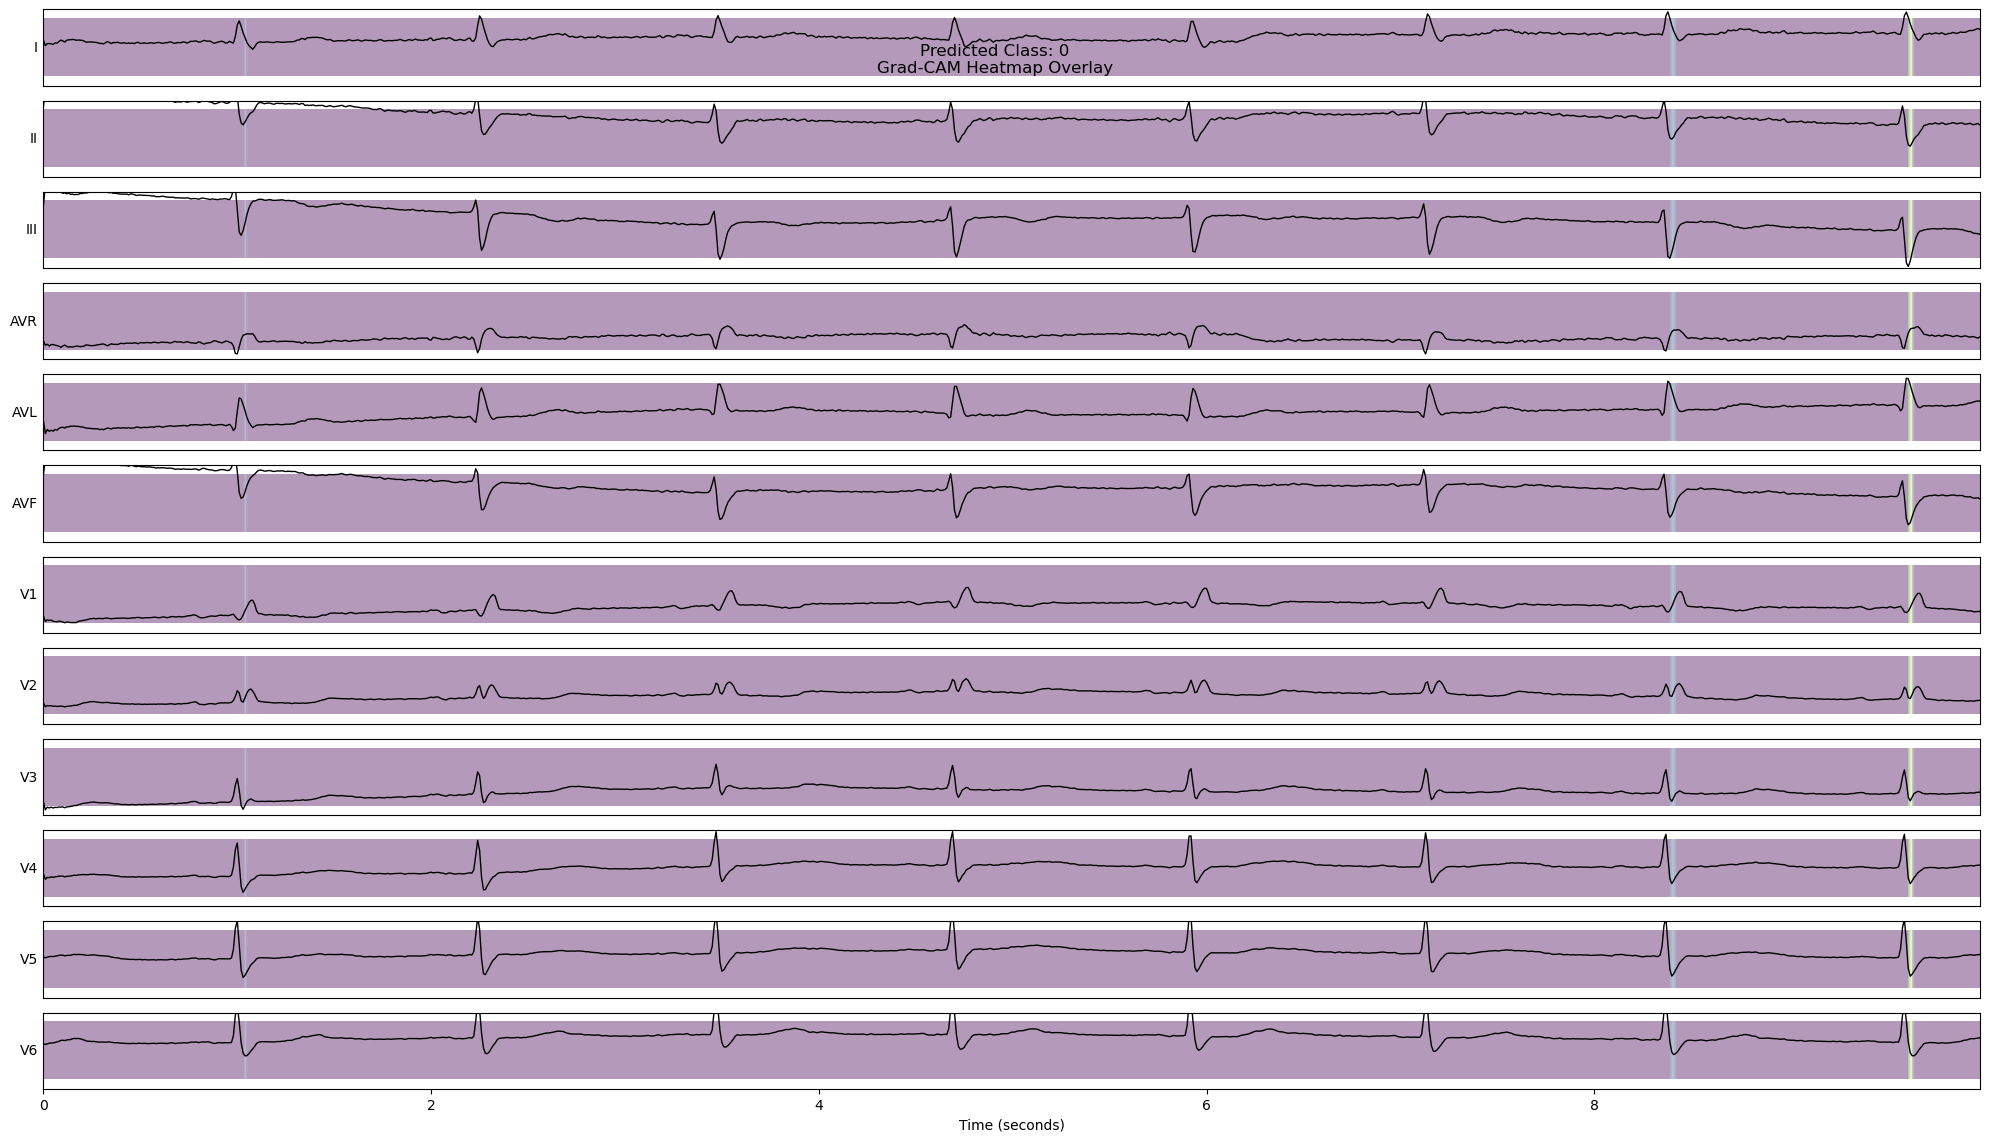

In [12]:
try:    
    # Resample and process signal
    resampled_signal = resample_signal(original_signal, original_fs, TARGET_FS)
    total_samples = resampled_signal.shape[0]
    
    print(f"Resampled samples: {total_samples}, Target FS: {TARGET_FS}")
    
    adjusted_signal = adjust_signal_length(resampled_signal, REQUIRED_LENGTH)
    
    input_tensor = tf.convert_to_tensor(
        np.expand_dims(adjusted_signal, 0), dtype=tf.float32
    )
    
    # Compute Grad-CAM
    heatmap_original, class_idx_original = compute_grad_cam(model, input_tensor, conv_layer_name)
    
    # Plot Grad-CAM
    print(f"Original Signal - Predicted Class: {class_idx_original}")
    plot_ecg_with_gradcam(
        adjusted_signal,
        heatmap_original,
        text['sig_name'],
        TARGET_FS,
        class_idx=class_idx_original)
        
except Exception as main_error:
    print(f"Critical error: {str(main_error)}")

In [13]:
def compute_shap_explanations(model, adjusted_signal, lead_names, fs, class_idx, window_size=100):
    """Compute SHAP values and aggregate over time windows using DeepExplainer"""
    # Create background dataset (using zeros for simplicity)
    background = np.zeros((1, *adjusted_signal.shape))  # (1, 1000, 12)
    
    # Initialize DeepExplainer
    explainer = shap.DeepExplainer(
        model,
        background
    )
    
    # Compute SHAP values for our instance
    shap_values = explainer.shap_values(adjusted_signal[np.newaxis, :, :])[0]  # (1, 1000, 12)
    
    # Aggregate SHAP values over time windows
    n_windows = adjusted_signal.shape[0] // window_size
    shap_heatmap = np.zeros_like(adjusted_signal)
    
    for window in range(n_windows):
        start = window * window_size
        end = start + window_size
        window_values = np.mean(shap_values[0, start:end, :], axis=0)
        shap_heatmap[start:end, :] = window_values

    # Normalize heatmap
    shap_heatmap_normalized = (shap_heatmap - np.min(shap_heatmap)) / (np.ptp(shap_heatmap) + 1e-8)
    
    plot_ecg_with_shap(adjusted_signal, shap_heatmap_normalized, lead_names, fs, class_idx)

In [14]:
def plot_ecg_with_shap(signal, heatmap, lead_names, fs, class_idx):
    """Plot ECG with SHAP importance overlay"""
    num_leads = signal.shape[1]
    time = np.arange(signal.shape[0]) / fs
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(num_leads, 1, figure=fig)
    
    for lead in range(num_leads):
        ax = fig.add_subplot(gs[lead, 0])
        vertical_offset = lead * 3
        ax.plot(time, signal[:, lead] + vertical_offset, linewidth=1, color='black')
        
        # Extract heatmap for current lead
        lead_heatmap = heatmap[:, lead]
        
        # Overlay heatmap
        heatmap_extent = [time[0], time[-1], vertical_offset - 1.5, vertical_offset + 1.5]
        ax.imshow(
            np.expand_dims(lead_heatmap, axis=0),
            cmap='viridis',
            aspect='auto',
            extent=heatmap_extent,
            alpha=0.4,
            origin='lower'
        )
        ax.set_ylabel(lead_names[lead], rotation=0, ha='right', va='center')
        ax.set_yticks([])
        ax.set_ylim(vertical_offset - 2, vertical_offset + 2)
        if lead != num_leads - 1:
            ax.set_xticks([])
    
    plt.suptitle(f"Predicted Class: {class_idx}\nSHAP Importance Overlay", y=0.92)
    plt.xlabel("Time (seconds)")
    plt.tight_layout()
    plt.show()

/opt/anaconda3/lib/python3.12/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 1000, 12))']
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(2, 1000, 12))']
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/numpy

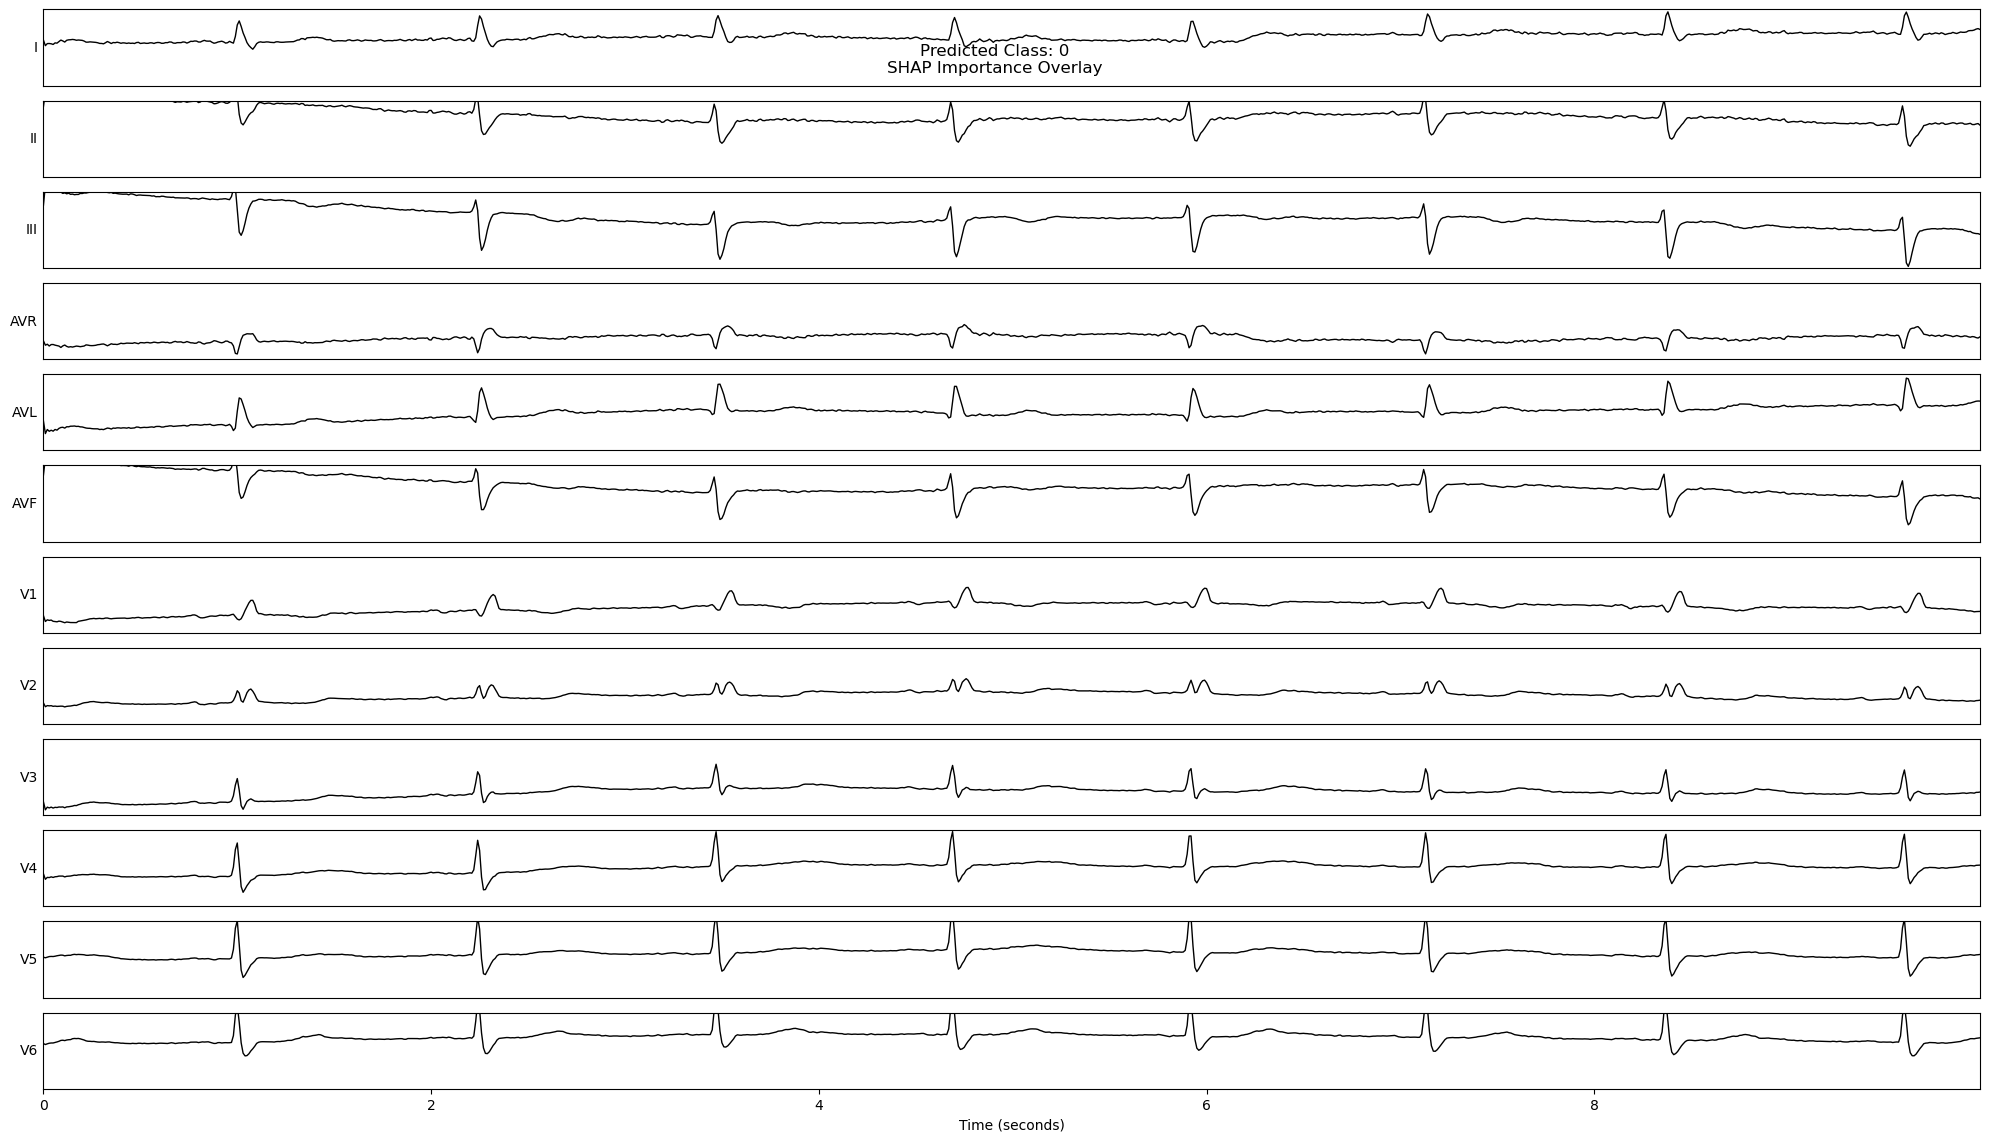

In [15]:
compute_shap_explanations(
    model=model,
    adjusted_signal=adjusted_signal,
    lead_names=text['sig_name'],
    fs=TARGET_FS,
    class_idx=class_idx_original,
    window_size=100
)

In [16]:
probability_output = model.predict(input_tensor)

print("Predicted probabilities:", probability_output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Predicted probabilities: [[0.01741714]]


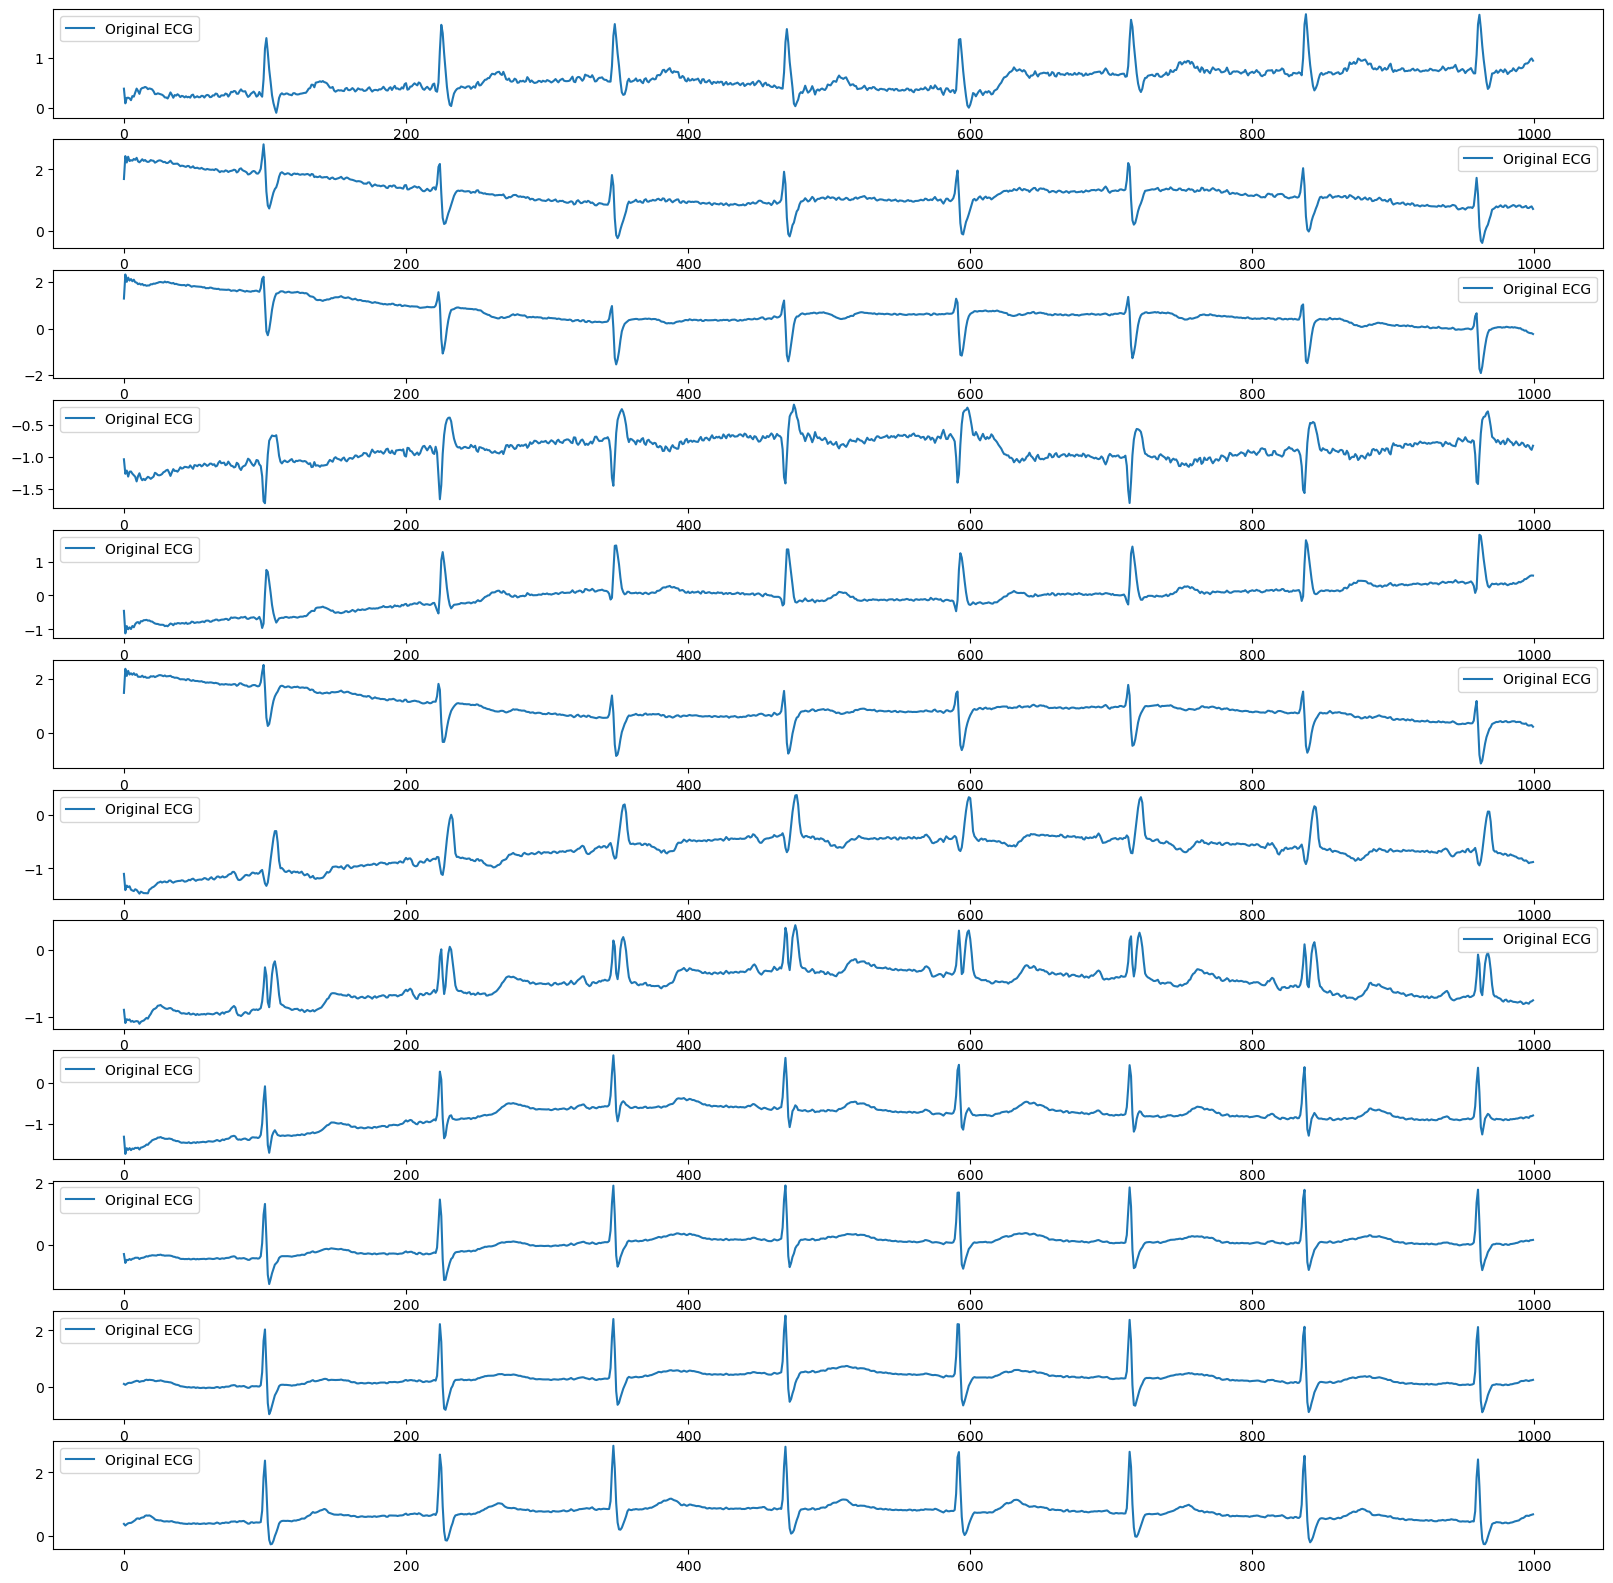

In [17]:
plt.figure(figsize=(20,20))
for i in range(12):
    plt.subplot(12,1,i+1)
    plt.plot(np.asarray(adjusted_signal)[:,i], label= "Original ECG")
    plt.legend()

In [18]:
def optimize_linear(grad, eps):

    axis = list(range(1, len(grad.get_shape())))
    avoid_zero_div = 1e-12

    # Take sign of gradient
    optimal_perturbation = tf.sign(grad)
    optimal_perturbation = tf.stop_gradient(optimal_perturbation)
    scaled_perturbation = tf.multiply(eps, optimal_perturbation)
    
    return scaled_perturbation

In [19]:
def bandpass_filter(signal, lowcut=0.5, highcut=50, fs=500, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

In [20]:
max_iterations = 100
eps = 0.01
target_class = 1 - true_label   # Flip the label
adv_x = tf.identity(input_tensor)

clinical_threshold = 0.01

for iteration in range(max_iterations):
    current_prob = model.predict(adv_x)[0][0]
    print(current_prob)
    
    # Success criteria for probabilistic outputs
    if (target_class == 1 and current_prob > 0.01) or \
       (target_class == 0 and current_prob < 0.001):
        print(f"Success at iteration {iteration}: Prob={current_prob:.4f}")
        break

    # Gradient calculation
    with tf.GradientTape() as tape:
        tape.watch(adv_x)
        pred = model(adv_x)
        loss = tf.keras.losses.binary_crossentropy(
            tf.constant([[target_class]], dtype=tf.float32), 
            pred
        )
        loss = -loss  # Gradient ASCENT for adversarial attack

    grads = tape.gradient(loss, adv_x)
    perturbation = optimize_linear(grads, eps)
    
    # ECG-specific filtering
    perturbation_filtered = np.array([
        bandpass_filter(perturbation[0,:,i], fs=fs, lowcut=0.5, highcut=50)
        for i in range(12)
    ])
    perturbation_filtered = np.expand_dims(perturbation_filtered.T, 0)

    adv_x = adv_x + perturbation_filtered
    #adv_x = tf.clip_by_value(adv_x, -2, 5)  #ECG voltage range

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
0.017417137
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
0.015287018
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
0.013417526
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
0.011822297
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
0.010485172
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
0.009370477
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
0.0084239505
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
0.007634468
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
0.0069652335
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
0.006394671
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
0.005906954
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
0.0054868963
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
0.005109369
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
0.004771942
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
0.004466654
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
0.004181894
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
0.0039122915
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
0.0036666654
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
0.0034424688
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
0.0032

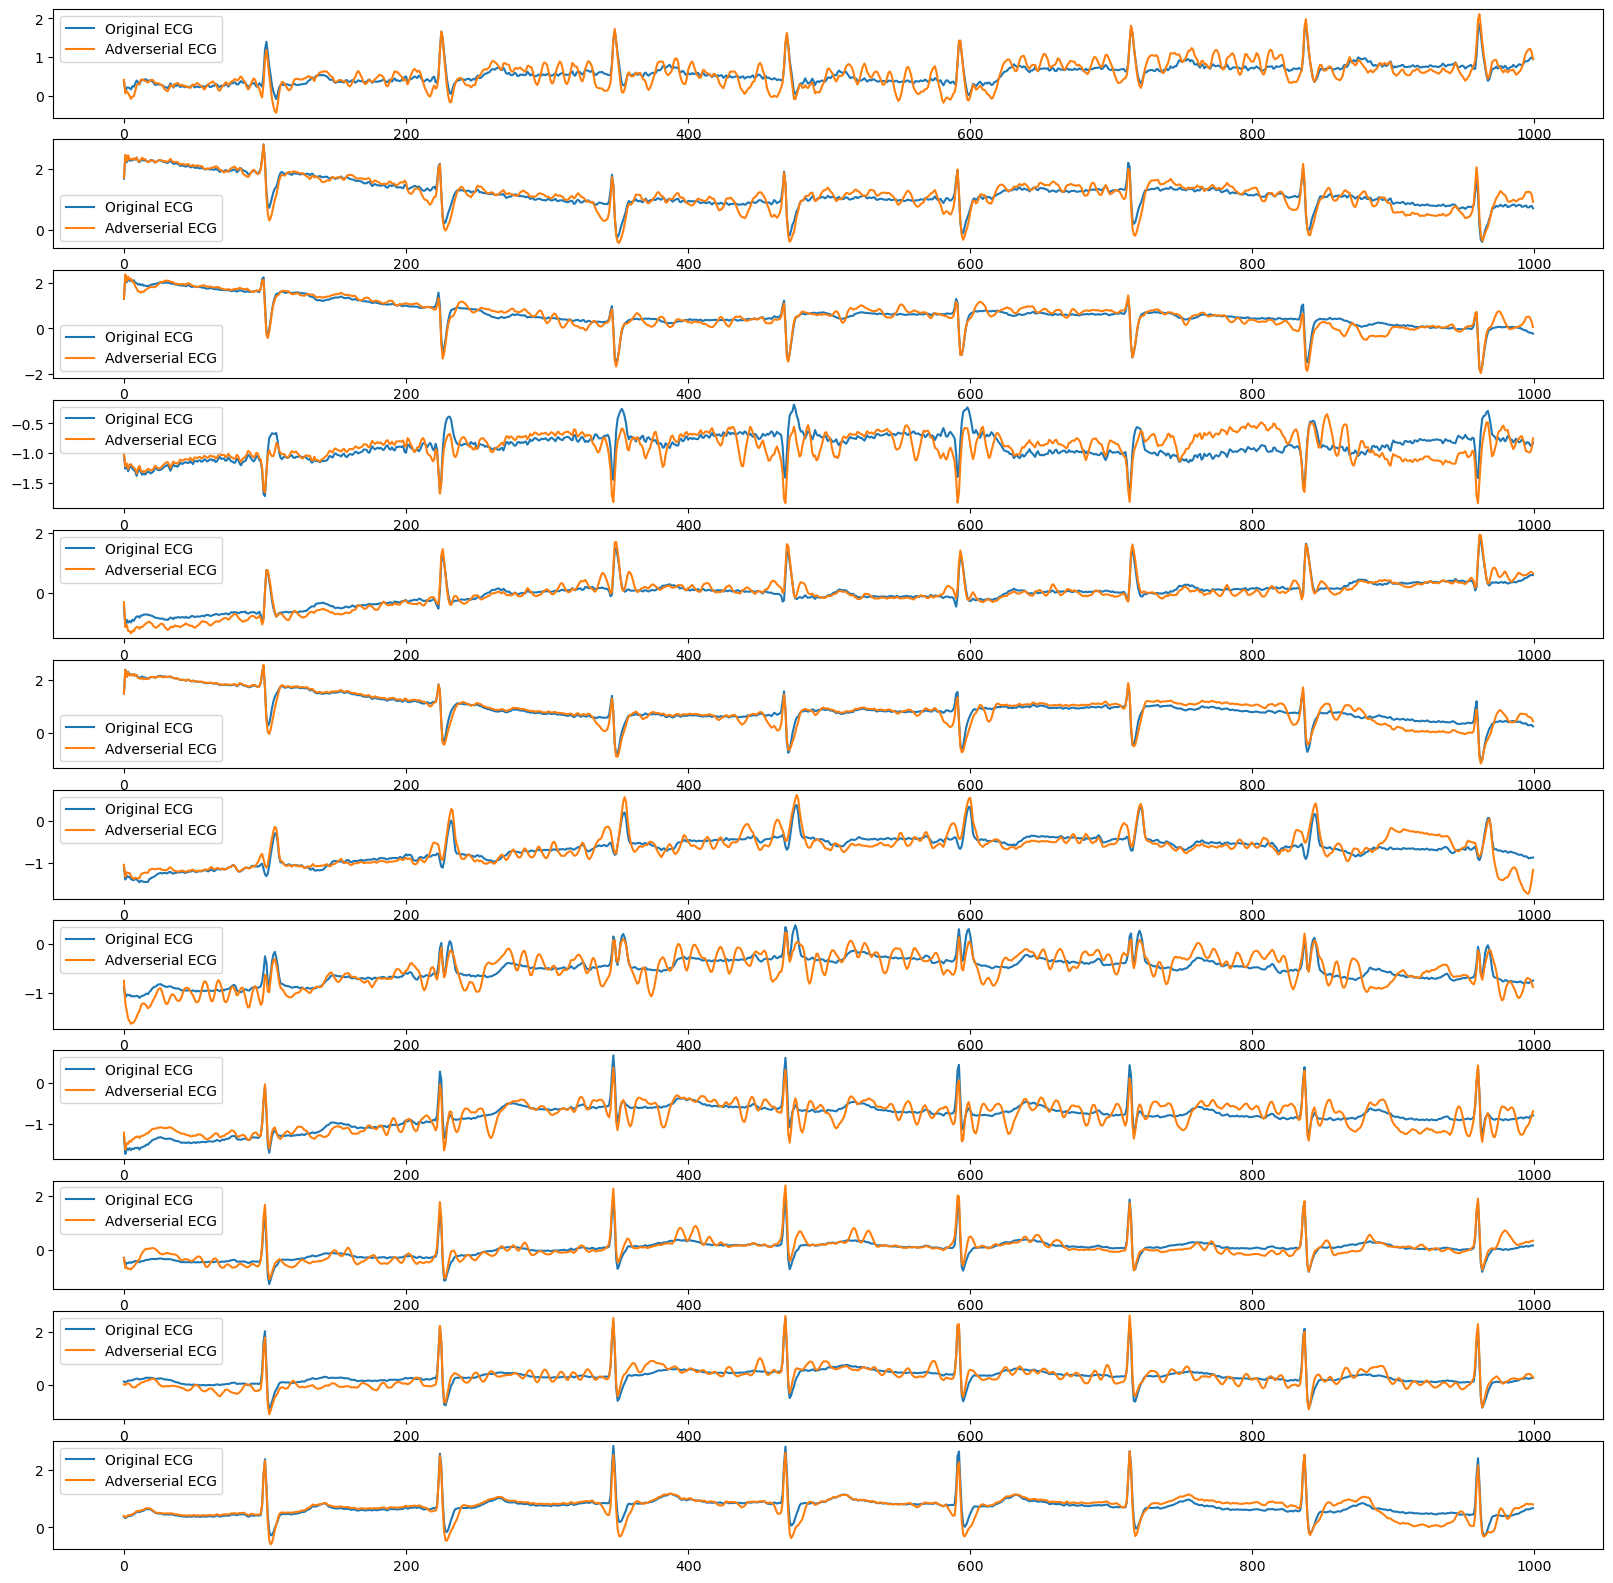

In [21]:
plt.figure(figsize=(20,20))
#adv_x = bandpass_filter(adv_x)
for i in range(12):
    plt.subplot(12,1,i+1)
    plt.plot(np.asarray(input_tensor)[0,:,i], label= "Original ECG")
    plt.plot(np.asarray(adv_x)[0,:,i], label= "Adverserial ECG")
    plt.legend()

In [22]:
original_pred = model.predict(input_tensor)
print("Original Prediction:", original_pred)
print(true_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Original Prediction: [[0.01741714]]
1


In [23]:
original_pred

array([[0.01741714]], dtype=float32)

In [24]:
print(f"true_label: {true_label}, type: {type(true_label)}")

true_label: 1, type: <class 'int'>


In [25]:
class ModelWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model  # Original model that outputs probabilities
        
    def call(self, x):
        probabilities = self.model(x)  # Model outputs probabilities
        logits = tf.math.log(probabilities / (1 - probabilities))  # Convert to logits
        return logits

# Wrap the original model
wrapped_model = ModelWrapper(model)

In [26]:
original_output = model(input_tensor)
print("Original model output (probabilities):", original_output)


wrapped_output = wrapped_model(input_tensor)
print("Wrapped model output (logits):", wrapped_output)

Original model output (probabilities): tf.Tensor([[0.01741714]], shape=(1, 1), dtype=float32)
Wrapped model output (logits): tf.Tensor([[-4.03273]], shape=(1, 1), dtype=float32)


In [27]:
def binary_loss(labels, logits):
    return tf.nn.sigmoid_cross_entropy_with_logits(
        labels=labels,  # Shape (1, 1)
        logits=logits   # Shape (1, 1)
    )

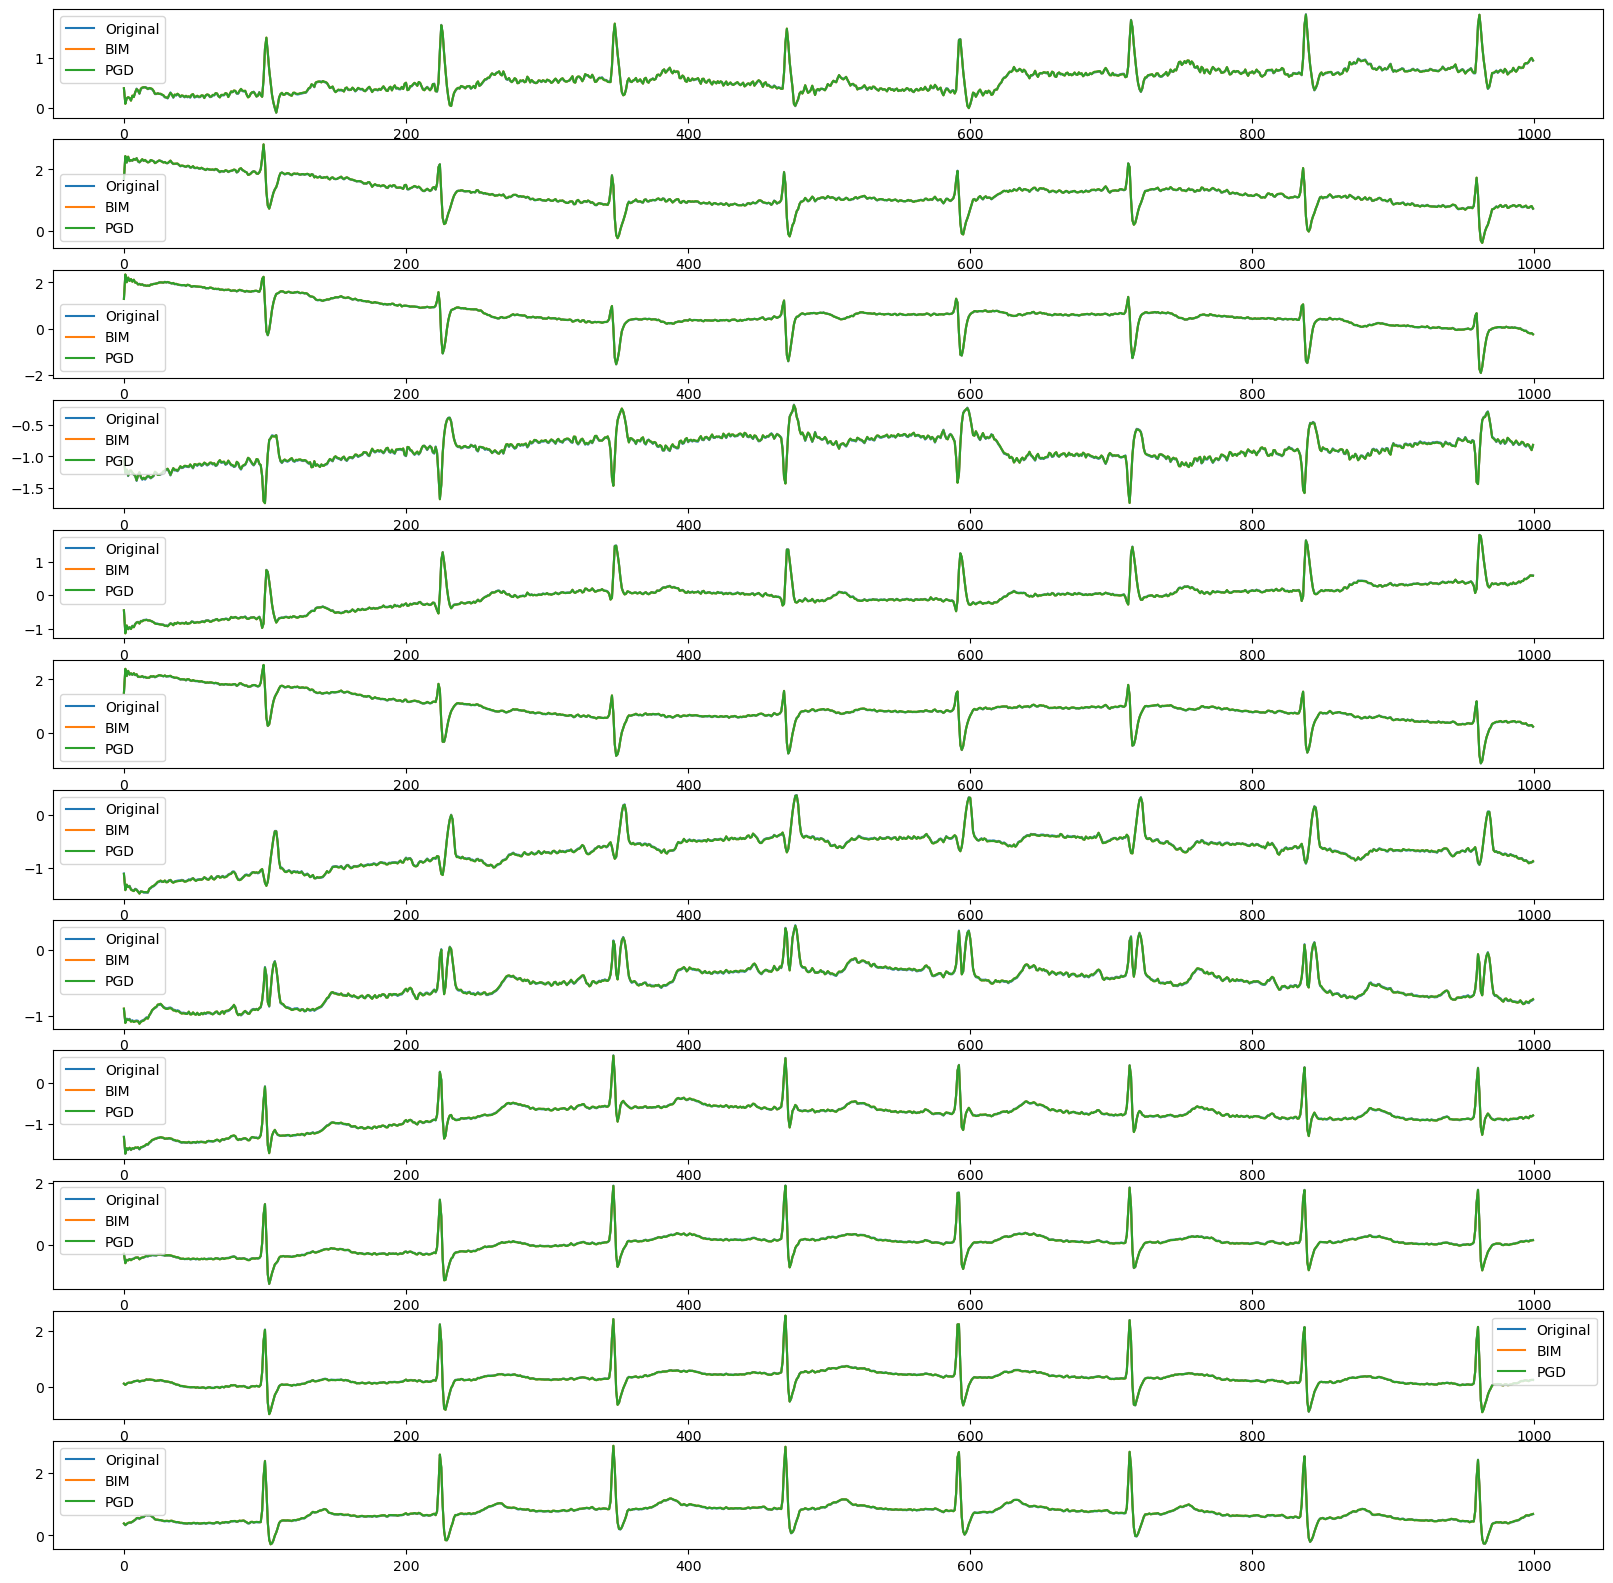

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Original: [[0.01741714]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
BIM: [[0.0129422]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PGD: [[0.0129422]]


In [28]:
# Attack parameters
true_label_tf = tf.constant([[true_label]], dtype=tf.float32)

eps = 0.01
alpha = eps / 10
steps = 10

# Generate adversarial examples
adv_bim = projected_gradient_descent(
    wrapped_model,  # Use wrapped model
    input_tensor,
    eps,
    alpha,
    steps,
    np.inf,
    y=true_label_tf,
    loss_fn=binary_loss  # Use custom binary loss
)

adv_pgd = projected_gradient_descent(
    wrapped_model,  # Use wrapped model
    input_tensor,
    eps,
    alpha,
    steps,
    np.inf,
    y=true_label_tf,
    loss_fn=binary_loss  # Use custom binary loss
)

# Visualization
plt.figure(figsize=(20, 20))
for i in range(12):
    plt.subplot(12, 1, i+1)
    plt.plot(adjusted_signal[:, i], label="Original")
    plt.plot(adv_bim.numpy()[0, :, i], label="BIM")
    plt.plot(adv_pgd.numpy()[0, :, i], label="PGD")
    plt.legend()
plt.show()

# Predictions
print("Original:", model.predict(input_tensor))
print("BIM:", model.predict(adv_bim))
print("PGD:", model.predict(adv_pgd))

Below this need to be try again

In [29]:
def extract_average_beat(signal_lead, sampling_rate):
    """Extract and average ECG beats using NeuroKit"""
    cleaned = nk.ecg_clean(signal_lead, sampling_rate=sampling_rate)
    _, rpeaks = nk.ecg_peaks(cleaned, sampling_rate=sampling_rate)
    
    if len(rpeaks["ECG_R_Peaks"]) == 0:
        raise ValueError("No R-peaks detected")
        
    segments = nk.ecg_segment(cleaned, rpeaks=rpeaks["ECG_R_Peaks"], 
                            sampling_rate=sampling_rate)
    beat_keys = [k for k in segments.keys() if k != 'Segment_0']
    return np.mean([segments[k]["Signal"] for k in beat_keys], axis=0)

In [30]:
def plot_comparison(original, adversarial, lead_names, title):
    """Plot original vs adversarial comparison"""
    plt.figure(figsize=(20, 12))
    for i in range(12):
        plt.subplot(12, 1, i+1)
        plt.plot(original[:, i], label="Original")
        plt.plot(adversarial[:, i], label="Adversarial")
        plt.ylabel(lead_names[i], rotation=0, ha='right')
        plt.yticks([])
        if i != 11: plt.xticks([])
    plt.suptitle(title)
    plt.legend()
    plt.show()

In [31]:
# Generate adversarial examples dictionary
attacks = {
    "bim": adv_bim,
    "pgd": adv_pgd
}

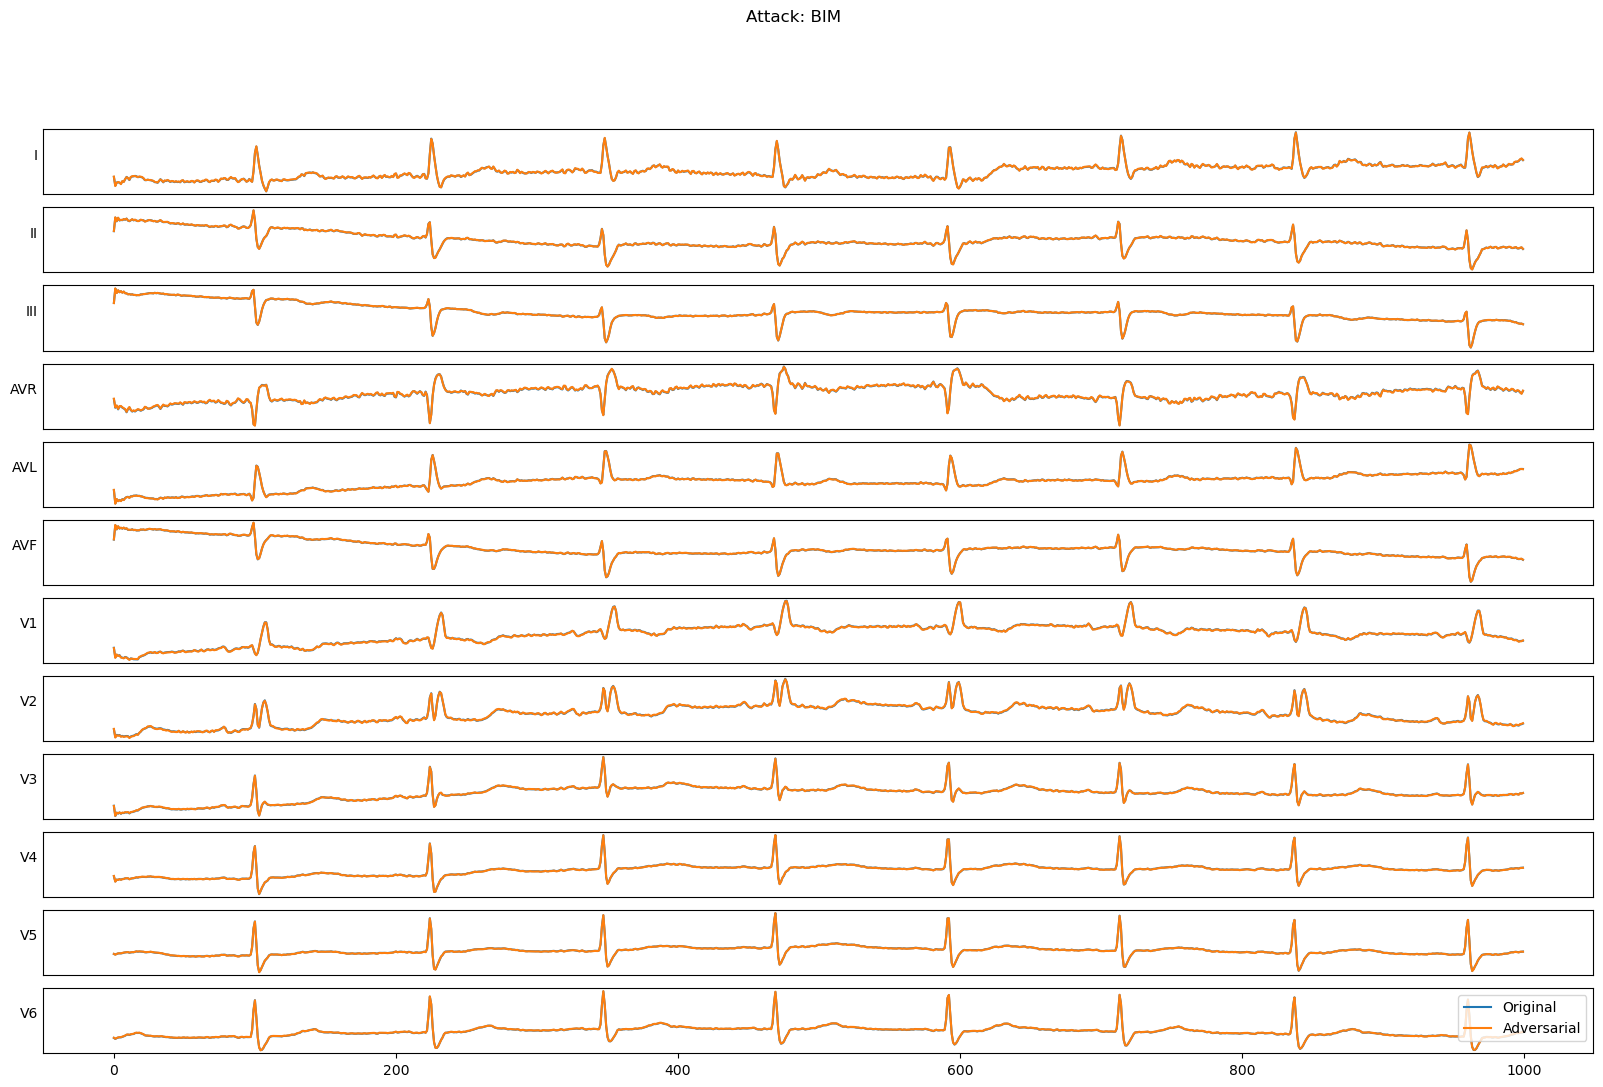

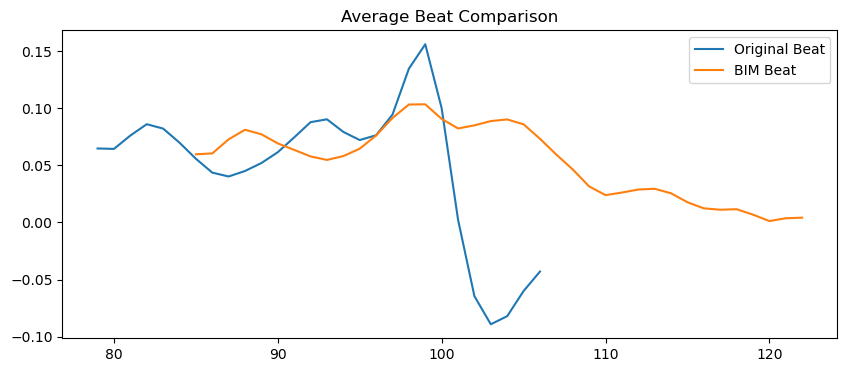

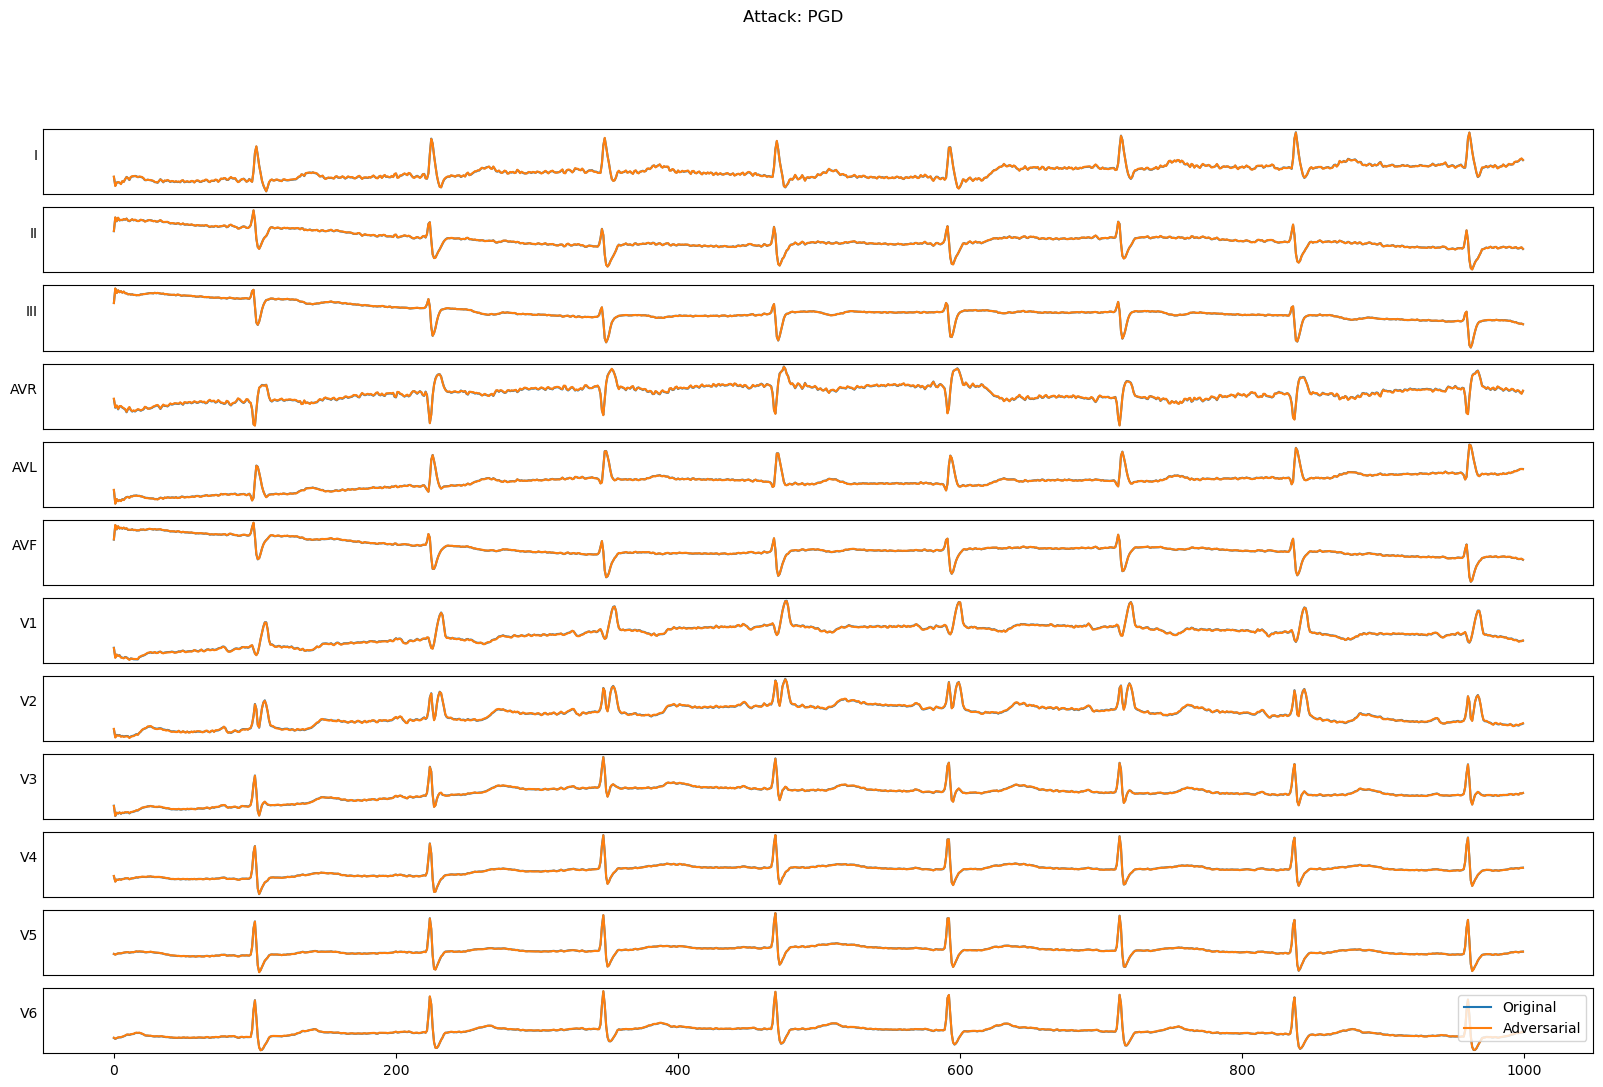

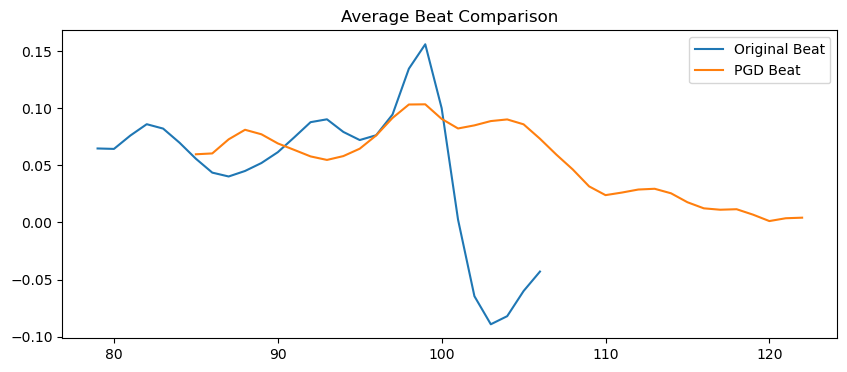

In [32]:
# Visualization and analysis
for name, adv_example in attacks.items():
    plot_comparison(adjusted_signal,  # Use actual variable
                  adv_example.numpy()[0], 
                  text['sig_name'], 
                  f"Attack: {name.upper()}")
    
    # Beat extraction and comparison
    try:
        orig_beat = extract_average_beat(adjusted_signal[:, 1], TARGET_FS)
        adv_beat = extract_average_beat(adv_example.numpy()[0, :, 1], TARGET_FS)
        
        plt.figure(figsize=(10, 4))
        plt.plot(orig_beat, label="Original Beat")
        plt.plot(adv_beat, label=f"{name.upper()} Beat")
        plt.title("Average Beat Comparison")
        plt.legend()
        plt.show()
        
    except ValueError as e:
        print(f"Beat comparison failed: {e}")